<a href="https://colab.research.google.com/github/alinatl/ml_hw/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
import math
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


На этом занятии мы попробуем задачу регрессии. Данные в этой же папке, будем тренироваться на датасете фильмов с IMDB

Перед обучением обучением модели, нужно подготовить данные:

- найти\собрать данные
- почистить и предобработать
- преобразовать в матрицы 


In [2]:
# импорты необходимых библиотек
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

# import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
data = pd.read_csv('IMDB-Movie-Data.csv')
print(data.shape)

data.head(3)

(1000, 12)


,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0


## Что делать с NaN?
Есть 3 варианта

In [4]:
# 1. Убрать строки с NaN
print(data.isna().any())
data.shape

Rank                  False
Title                 False
Genre                 False
Description           False
Director              False
Actors                False
Year                  False
Runtime (Minutes)     False
Rating                False
Votes                 False
Revenue (Millions)     True
Metascore              True
dtype: bool


(1000, 12)

In [5]:
print(data.shape)
tmp = data.dropna()
tmp.shape

(1000, 12)


(838, 12)

In [6]:
# 2. Превратить NaN в 0
print(data.shape)
tmp = data.fillna(0)
print(tmp.shape)

(1000, 12)
(1000, 12)


In [7]:
# 3. Превратить NaN в средние значения по колонке

# вычисляем средние для колонок с пустыми значениями
meta_mean = data.Metascore.mean()
rev_mean = data['Revenue (Millions)'].mean()

#заменяем пустоты на средние значения
data.Metascore.fillna(meta_mean, inplace=True)
data['Revenue (Millions)'].fillna(rev_mean, inplace=True)

# проверяем присутствие NaN
data.isna().any()

Rank                  False
Title                 False
Genre                 False
Description           False
Director              False
Actors                False
Year                  False
Runtime (Minutes)     False
Rating                False
Votes                 False
Revenue (Millions)    False
Metascore             False
dtype: bool

## Подготовка данных

Попробуем предсказывать рейтинг фильма по данным его описания, года, длины в минутах и кассовых сборов

Колонка "Rating" станет **целевой переменной, или таргетом** (y)<br>
Остальных данные будут **обучающей выборкой** (X)

In [8]:
data.Description

0      A group of intergalactic criminals are forced ...
1      Following clues to the origin of mankind, a te...
2      Three girls are kidnapped by a man with a diag...
3      In a city of humanoid animals, a hustling thea...
4      A secret government agency recruits some of th...
                             ...                        
995    A tight-knit team of rising investigators, alo...
996    Three American college students studying abroa...
997    Romantic sparks occur between two dance studen...
998    A pair of friends embark on a mission to reuni...
999    A stuffy businessman finds himself trapped ins...
Name: Description, Length: 1000, dtype: object

In [9]:
# подготовим описания фильмов
data["text"] = data.Description.apply(lambda x: x.lower().split()) 

data["text"]

0      [a, group, of, intergalactic, criminals, are, ...
1      [following, clues, to, the, origin, of, mankin...
2      [three, girls, are, kidnapped, by, a, man, wit...
3      [in, a, city, of, humanoid, animals,, a, hustl...
4      [a, secret, government, agency, recruits, some...
                             ...                        
995    [a, tight-knit, team, of, rising, investigator...
996    [three, american, college, students, studying,...
997    [romantic, sparks, occur, between, two, dance,...
998    [a, pair, of, friends, embark, on, a, mission,...
999    [a, stuffy, businessman, finds, himself, trapp...
Name: text, Length: 1000, dtype: object

In [ ]:
data.text.values

In [11]:
input_text = list(data.text.values)

In [12]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]
documents[10:12]

[TaggedDocument(words=['the', 'adventures', 'of', 'writer', 'newt', 'scamander', 'in', 'new', "york's", 'secret', 'community', 'of', 'witches', 'and', 'wizards', 'seventy', 'years', 'before', 'harry', 'potter', 'reads', 'his', 'book', 'in', 'school.'], tags=[10]),
 TaggedDocument(words=['the', 'story', 'of', 'a', 'team', 'of', 'female', 'african-american', 'mathematicians', 'who', 'served', 'a', 'vital', 'role', 'in', 'nasa', 'during', 'the', 'early', 'years', 'of', 'the', 'u.s.', 'space', 'program.'], tags=[11])]

обучаем модель на текстах описаний фильмов (можно поизменять параметры)

In [13]:
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [ ]:
model.save("D2V.model") # сохранение модели

In [14]:
# так можно посмотреть на векторы текстов, на которых училась модель
# индекс [] около documents -- это индекс текста из датасета

model[documents[0].tags[0]]


array([-0.08786903, -0.06978936,  0.06302686,  0.05867736, -0.08927106],
      dtype=float32)

Теперь нужно добавить векторы в датасет с остальными параметрами

In [15]:
# создадим список с векторами для каждого текста
vectors = []
for x in documents:
    vec = list(model[x.tags][0])
    vectors.append(vec)

In [16]:
# так получим датафрейм, где все компоненты векторов в отдельных столбцах
split_df = pd.DataFrame(vectors,
                        columns=['v1', 'v2', 'v3','v4',"v5"])

split_df


,v1,v2,v3,v4,v5
0,-0.087869,-0.069789,0.063027,0.058677,-0.089271
1,-0.012825,0.038783,0.074296,-0.024311,-0.126780
2,-0.122349,-0.050147,0.042454,-0.119388,-0.123546
3,-0.117587,-0.009491,-0.078312,-0.204445,-0.049120
4,-0.034326,-0.089238,-0.035161,0.000544,-0.097287
...,...,...,...,...,...
995,-0.089425,-0.164598,0.038575,-0.183571,-0.139259
996,0.004840,-0.046548,-0.044319,-0.036256,-0.019382
997,-0.145712,-0.039303,-0.100523,-0.010981,0.020828
998,-0.048197,-0.077285,-0.043909,-0.022356,-0.051014


In [17]:
# теперь добавим его к основному датафрейму
result = data.join(split_df, how='left')
result.shape

(1000, 18)

In [18]:
result

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,text,v1,v2,v3,v4,v5
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.130000,76.0,"[a, group, of, intergalactic, criminals, are, ...",-0.087869,-0.069789,0.063027,0.058677,-0.089271
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.460000,65.0,"[following, clues, to, the, origin, of, mankin...",-0.012825,0.038783,0.074296,-0.024311,-0.126780
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.120000,62.0,"[three, girls, are, kidnapped, by, a, man, wit...",-0.122349,-0.050147,0.042454,-0.119388,-0.123546
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.320000,59.0,"[in, a, city, of, humanoid, animals,, a, hustl...",-0.117587,-0.009491,-0.078312,-0.204445,-0.049120
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.020000,40.0,"[a, secret, government, agency, recruits, some...",-0.034326,-0.089238,-0.035161,0.000544,-0.097287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Secret in Their Eyes,"Crime,Drama,Mystery","A tight-knit team of rising investigators, alo...",Billy Ray,"Chiwetel Ejiofor, Nicole Kidman, Julia Roberts...",2015,111,6.2,27585,82.956376,45.0,"[a, tight-knit, team, of, rising, investigator...",-0.089425,-0.164598,0.038575,-0.183571,-0.139259
996,997,Hostel: Part II,Horror,Three American college students studying abroa...,Eli Roth,"Lauren German, Heather Matarazzo, Bijou Philli...",2007,94,5.5,73152,17.540000,46.0,"[three, american, college, students, studying,...",0.004840,-0.046548,-0.044319,-0.036256,-0.019382
997,998,Step Up 2: The Streets,"Drama,Music,Romance",Romantic sparks occur between two dance studen...,Jon M. Chu,"Robert Hoffman, Briana Evigan, Cassie Ventura,...",2008,98,6.2,70699,58.010000,50.0,"[romantic, sparks, occur, between, two, dance,...",-0.145712,-0.039303,-0.100523,-0.010981,0.020828
998,999,Search Party,"Adventure,Comedy",A pair of friends embark on a mission to reuni...,Scot Armstrong,"Adam Pally, T.J. Miller, Thomas Middleditch,Sh...",2014,93,5.6,4881,82.956376,22.0,"[a, pair, of, friends, embark, on, a, mission,...",-0.048197,-0.077285,-0.043909,-0.022356,-0.051014


In [19]:
# переопределим датасет, оставив только важное

data_sm = result[['Runtime (Minutes)',"Year",
                'Rating', 'Votes',
                'Revenue (Millions)','Metascore',"v1","v2","v3","v4","v5"]
              ]


data_sm.head(3)

,Runtime (Minutes),Year,Rating,Votes,Revenue (Millions),Metascore,v1,v2,v3,v4,v5
0,121,2014,8.1,757074,333.13,76.0,-0.087869,-0.069789,0.063027,0.058677,-0.089271
1,124,2012,7.0,485820,126.46,65.0,-0.012825,0.038783,0.074296,-0.024311,-0.126780
2,117,2016,7.3,157606,138.12,62.0,-0.122349,-0.050147,0.042454,-0.119388,-0.123546


## Подготавливаем матрицы

In [20]:
# определяем X и y

X = data_sm.drop(["Rating"],axis=1).values 

display(X, X.shape)

array([[ 1.21000000e+02,  2.01400000e+03,  7.57074000e+05, ...,
         6.30268604e-02,  5.86773604e-02, -8.92710611e-02],
       [ 1.24000000e+02,  2.01200000e+03,  4.85820000e+05, ...,
         7.42958561e-02, -2.43106820e-02, -1.26779616e-01],
       [ 1.17000000e+02,  2.01600000e+03,  1.57606000e+05, ...,
         4.24537063e-02, -1.19388312e-01, -1.23545744e-01],
       ...,
       [ 9.80000000e+01,  2.00800000e+03,  7.06990000e+04, ...,
        -1.00522608e-01, -1.09814741e-02,  2.08283085e-02],
       [ 9.30000000e+01,  2.01400000e+03,  4.88100000e+03, ...,
        -4.39092591e-02, -2.23561339e-02, -5.10135554e-02],
       [ 8.70000000e+01,  2.01600000e+03,  1.24350000e+04, ...,
        -8.82013142e-02,  1.22023802e-02,  2.47897934e-02]])

(1000, 10)

In [21]:
data_sm.isna().any()

Runtime (Minutes)     False
Year                  False
Rating                False
Votes                 False
Revenue (Millions)    False
Metascore             False
v1                    False
v2                    False
v3                    False
v4                    False
v5                    False
dtype: bool

In [22]:
y = data_sm['Rating'].values # отдельно вынесли массив со значениями скорости ветра
y.shape

(1000,)

Иногда бывает полезно [нормализовать](https://en.wikipedia.org/wiki/Normalization_(statistics)) данные: это позволяет исправить ситуацию, когда признаки представлены в разных единацах измерения. 
Для этого используется StandardScaler. 

До нормализации:

In [23]:
list(X[0])

[121.0,
 2014.0,
 757074.0,
 333.13,
 76.0,
 -0.08786902576684952,
 -0.06978936493396759,
 0.06302686035633087,
 0.05867736041545868,
 -0.08927106112241745]

In [24]:
# использзуем стандартизатор
sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(X), y, random_state=42)

После:

In [25]:
list(sc.fit_transform(X)[0])

[0.4163497512303056,
 0.37979525138136244,
 3.1126899627963738,
 2.5961363010556906,
 1.0233613578368184,
 -0.024610670701774227,
 0.2084134694678601,
 1.5890265014579448,
 2.0306942683403677,
 0.0508871906909454]

теперь с данными удобнее работать и обучать

In [26]:
# задаем модель регрессора
# силу регуляризации можно варьировать параметром alpha
regressor = Ridge() 


# обучаем
regressor.fit(X_train, y_train)

Ridge()

In [27]:
# давайте предскажем результат для тестовой выборки

y_preds = regressor.predict(X_test)

### оценка результатов алгоритма

В качестве метрики будем использовать [среднюю абсолютную ошибку](https://www.youtube.com/watch?v=ZejnwbcU8nw). Она показывает отклонение от правильного ответа в тех же единах измерения

*(а вообще есть [разные способы](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b))*

In [28]:
mean_absolute_error(y_test, y_preds) 

0.49074852360444376

Попробуйте разные значения для параметра регуляризации alpha при обучении модели. Как они влияют на величину ошибки?

In [122]:
def clean_data(text):
  wordsFiltered = []
  text = word_tokenize(text)
  for w in text:
    if w not in stopWords and w not in string.punctuation:
        wordsFiltered.append(lemmatizer.lemmatize(w.lower()))
  return wordsFiltered

def preproc(preproc):
  if preproc == True:
    data["text"] = data.Description.apply(clean_data) 
  else:
    data["text"] = data.Description.apply(lambda x: x.lower().split()) 
  input_text = list(data.text.values)
  documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]
  return documents


def evaluate_Doc(documents, vector_size, min_count, epochs):
  model = Doc2Vec(documents, 
                  vector_size=vector_size, 
                  min_count = min_count, 
                  epochs = epochs,
                  seed = 42)
  vectors = []
  for x in documents:
      vec = list(model[x.tags][0])
      vectors.append(vec)
  split_df = pd.DataFrame(vectors,
                          columns=[x for x in range(vector_size)])
  data_sm = data[['Runtime (Minutes)',"Year",
                  'Rating', 'Votes',
                  'Revenue (Millions)','Metascore']].join(split_df, how='left')
  X = data_sm.drop(["Rating"],axis=1).values 
  y = data_sm['Rating'].values 

  return X, y

def evaluate_regression(model, X, y): 
  sc = StandardScaler()
  X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(X), y, random_state=42)
  model.fit(X_train, y_train)
  y_preds = model.predict(X_test)
  return round(mean_absolute_error(y_test, y_preds), 3), round(mean_squared_error(y_test, y_preds), 3), round(math.sqrt(mean_squared_error(y_test, y_preds)), 3)

# Параметр альфа для Ridge и Lasso

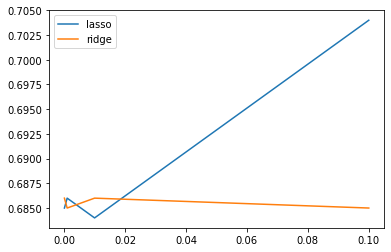

In [103]:
scores_ridge = []
index = [0.0001, 0.001, 0.01, 0.1]
for alpha in index:
  X, y = evaluate_Doc(documents = preproc(False), vector_size = 4, min_count = 2, epochs = 20)
  scores_ridge.append(evaluate_regression(Ridge(alpha = alpha), X, y)[2])
  
scores_lasso = []
index = [0.0001, 0.001, 0.01, 0.1]
for alpha in index:
  X, y = evaluate_Doc(documents = preproc(False), vector_size = 4, min_count = 2, epochs = 20)
  scores_lasso.append(evaluate_regression(Lasso(alpha = alpha), X, y)[2])
  
plt.plot(index, scores_lasso)
plt.plot(index, scores_ridge)
plt.legend(['lasso', 'ridge'], loc=2)
plt.show()

Lasso демонстрирует лучшие результаты с параметром 0 < альфа < 1, а Ridge на имеющихся данных показывает примерно одинаковые значения score вне зависимости от параметра альфа.

## Параметры Doc2vec



*   При увеличении размера вектора (vector_size = 32), Lasso демонстрирует лучшие результаты по сравнению с другими моделями, поскольку умеет занулять ненужные фичи у вектора.
*   Лучшиие результаты показывают данные без специального препроцессинга (удаление пунктуации, стопслов, лемматизация). Скорее всего это так из-за маленького размера словаря.




In [79]:
print('vector_size =', 4)
for model in [LinearRegression(), Ridge(alpha = 0.1), Lasso(alpha = 0.01)]:
  scores_row = []
  for prep in [True, False]:
    X, y = evaluate_Doc(documents = preproc(prep), vector_size = 4, min_count = 2, epochs = 20)
    scores_row.append(evaluate_regression(model, X, y))
  print('model:', model)
  data_results =  pd.DataFrame(scores_row, columns = ['MAE', 'MSE', 'RMSE'], index = ['prep_yes', 'prep_no'])
  print(data_results, '\n')

vector_size = 4
model: LinearRegression()
            MAE   MSE   RMSE
prep_yes  0.491  0.47  0.686
prep_no   0.489  0.47  0.686 

model: Ridge(alpha=0.1)
            MAE    MSE   RMSE
prep_yes  0.491  0.471  0.686
prep_no   0.490  0.471  0.686 

model: Lasso(alpha=0.01)
            MAE    MSE   RMSE
prep_yes  0.489  0.468  0.684
prep_no   0.488  0.468  0.684 



In [80]:
print('vector_size =', 32)
for model in [LinearRegression(), Ridge(alpha = 0.1), Lasso(alpha = 0.01)]:
  scores_row = []
  for prep in [True, False]:
    X, y = evaluate_Doc(documents = preproc(prep), vector_size = 32, min_count = 2, epochs = 20)
    scores_row.append(evaluate_regression(model, X, y))
  print('model:', model)
  data_results =  pd.DataFrame(scores_row, columns = ['MAE', 'MSE', 'RMSE'], index = ['prep_yes', 'prep_no'])
  print(data_results, '\n')

vector_size = 32
model: LinearRegression()
            MAE    MSE   RMSE
prep_yes  0.511  0.497  0.705
prep_no   0.508  0.492  0.702 

model: Ridge(alpha=0.1)
            MAE    MSE   RMSE
prep_yes  0.512  0.498  0.706
prep_no   0.510  0.495  0.703 

model: Lasso(alpha=0.01)
            MAE    MSE   RMSE
prep_yes  0.492  0.468  0.684
prep_no   0.488  0.468  0.684 



Увеличение значения минимальной частоты встречаемости слова (min_count = 10) почти не влияет на качество обучения:

In [112]:
print('min_count =', 10)
for model in [LinearRegression(), Ridge(alpha = 0.1), Lasso(alpha = 0.01)]:
  scores_row = []
  for prep in [True, False]:
    X, y = evaluate_Doc(documents = preproc(prep), vector_size = 4, min_count = 10, epochs = 20)
    scores_row.append(evaluate_regression(model, X, y))
  print('model:', model)
  data_results =  pd.DataFrame(scores_row, columns = ['MAE', 'MSE', 'RMSE'], index = ['prep_yes', 'prep_no'])
  print(data_results, '\n')

min_count = 10
model: LinearRegression()
            MAE    MSE   RMSE
prep_yes  0.487  0.469  0.685
prep_no   0.487  0.468  0.684 

model: Ridge(alpha=0.1)
            MAE    MSE   RMSE
prep_yes  0.485  0.467  0.683
prep_no   0.488  0.466  0.683 

model: Lasso(alpha=0.01)
            MAE    MSE   RMSE
prep_yes  0.486  0.468  0.684
prep_no   0.487  0.466  0.683 



Увеличение количества эпох при обучении улучшает значения метрик, причем данные с препроцессингом демонстрируют лучшие результаты, чем данные без препроцессинга:

In [117]:
print('epochs = ', 100)
for model in [LinearRegression(), Ridge(alpha = 0.1), Lasso(alpha = 0.01)]:
  scores_row = []
  for prep in [True, False]:
    X, y = evaluate_Doc(documents = preproc(prep), vector_size = 4, min_count = 2, epochs = 100)
    scores_row.append(evaluate_regression(model, X, y))
  print('model:', model)
  data_results =  pd.DataFrame(scores_row, columns = ['MAE', 'MSE', 'RMSE'], index = ['prep_yes', 'prep_no'])
  print(data_results, '\n')

epochs =  100
model: LinearRegression()
            MAE    MSE   RMSE
prep_yes  0.486  0.465  0.682
prep_no   0.492  0.473  0.688 

model: Ridge(alpha=0.1)
            MAE    MSE   RMSE
prep_yes  0.484  0.463  0.680
prep_no   0.493  0.470  0.686 

model: Lasso(alpha=0.01)
            MAE    MSE   RMSE
prep_yes  0.486  0.465  0.682
prep_no   0.487  0.471  0.686 



Итог: Существенно улучшить значения метрик изменением гиперпараметров и препроцессингом у меня не получилось. Основные выводы:
*   При разреженных векторах лучше использовать Lasso
*   Ridge полезен при большом наборе данных (чтобы избежать переобучения) и не имеет серьезного преимущества по сравнению с линейной регрессией на маленьком датасете.
*   Параметр, который оказал существенное влияние на метрики: количество эпох в модели Doc2vec.





